# Population Map by Communes

In [1]:
from pynsee.geodata import *

import geopandas as gpd
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import descartes

In [2]:
# get geographical data list
geodata_list = get_geodata_list()
# get departments geographical limits
com = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:commune')

Previously saved data used
/home/jovyan/.cache/insee/pynsee/2ac583be54e866b2b1b30fb0113c1fd0.csv
Set update=True to get the most up-to-date data
Previously saved data used
/home/jovyan/.cache/insee/pynsee/d64a941ae07b7f39b02b9d5fd1828888.csv
Set update=True to get the most up-to-date data


In [3]:
geodata_list.head()

,Topic,DataFormat,ApiVersion,Identifier,Abstract,Title,DefaultCRS
0,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement,édition 2021,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement.t...,urn:ogc:def:crs:EPSG::4326
1,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_m...,édition 2021,ADMINEXPRESS-COG-CARTO.LATEST:arrondissement_m...,urn:ogc:def:crs:EPSG::4326
2,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:canton,édition 2021,ADMINEXPRESS-COG-CARTO.LATEST:canton.title,urn:ogc:def:crs:EPSG::4326
3,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_arrondis...,édition 2021,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_arrondis...,urn:ogc:def:crs:EPSG::4326
4,administratif,WFS,2.0.0,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_commune,édition 2021,ADMINEXPRESS-COG-CARTO.LATEST:chflieu_commune....,urn:ogc:def:crs:EPSG::4326


In [4]:
com.head()

,id,nom,nom_m,insee_com,statut,population,insee_can,insee_arr,insee_dep,insee_reg,siren_epci,geometry,bbox
0,COMMUNE_0000001269976025,Le Diamant,LE DIAMANT,97206,Commune simple,5576,NR,3,972,02,249720053,"(POLYGON ((-61.03796203 14.44243963, -61.03796...","[-61.05752701, 14.44195304, -60.97955022, 14.5..."
1,COMMUNE_0000001269976019,Rivière-Salée,RIVIERE-SALEE,97221,Commune simple,11857,NR,3,972,02,249720053,"(POLYGON ((-60.98018682 14.55133412, -60.97741...","[-61.0045328, 14.49644478, -60.92012979, 14.55..."
2,COMMUNE_0000001269976026,Les Anses-d'Arlet,LES ANSES-D'ARLET,97202,Commune simple,3541,NR,3,972,02,249720053,"(POLYGON ((-61.05642605 14.50627136, -61.05506...","[-61.10092833, 14.45388364, -61.04630474, 14.5..."
3,COMMUNE_0000001169858680,Basse-Terre,BASSE-TERRE,97105,Préfecture de région,10046,06,1,971,01,249710070,"(POLYGON ((-61.73063929 16.01166306, -61.73087...","[-61.74627695, 15.98565975, -61.71248573, 16.0..."
4,COMMUNE_0000001169858692,Capesterre-de-Marie-Galante,CAPESTERRE-DE-MARIE-GALANTE,97108,Commune simple,3293,10,2,971,01,249710047,"(POLYGON ((-61.2246038 15.96451578, -61.224525...","[-61.26424019, 15.87077191, -61.1949177, 15.96..."


In [5]:
# remove overseas departments
comfrm = com[~com['insee_dep'].isin(['971', '972', '973', '974', '976'])]

In [6]:
map = gpd.GeoDataFrame(comfrm).set_crs("EPSG:4326")
map['REF_AREA'] = 'D' + map['insee_dep']

map = map.to_crs(epsg=3035)
map["area"] = map['geometry'].area / 10**6
map = map.to_crs(epsg=4326)

map['density'] = map['population'] / map["area"]

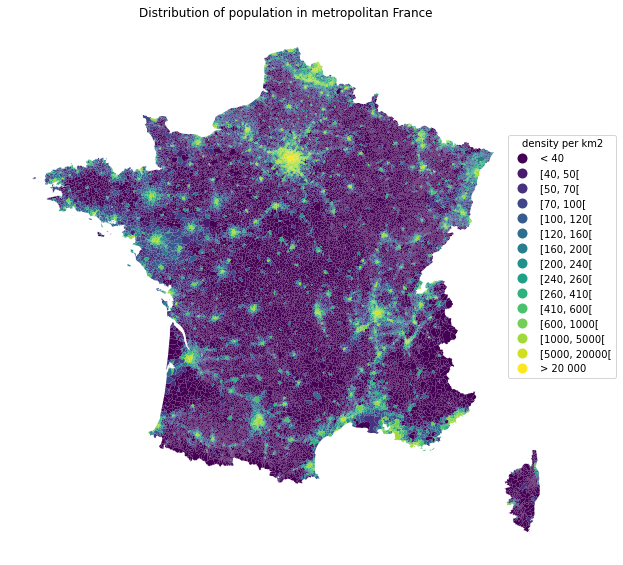

In [7]:

map.loc[map.density < 40, 'range'] = "< 40"
map.loc[map.density >= 20000, 'range'] = "> 20 000"

density_ranges = [40, 50, 70, 100, 120, 160, 200, 240, 260, 410, 600, 1000, 5000, 20000]
list_ranges = []
list_ranges.append( "< 40")

for i in range(len(density_ranges)-1):
    min = density_ranges[i]
    max = density_ranges[i+1]
    range_string = "[{}, {}[".format(min, max)
    map.loc[(map.density >= min) & (map.density < max), 'range'] = range_string
    list_ranges.append(range_string)

list_ranges.append("> 20 000")

map['range'] = map['range'].astype( CategoricalDtype(categories=list_ranges, ordered=True))

fig, ax = plt.subplots(1,1,figsize=[10,10])
map.plot(column='range', cmap=cm.viridis, 
    legend=True, ax=ax,
    legend_kwds={'bbox_to_anchor': (1.1, 0.8),
                 'title':'density per km2'})
ax.set_axis_off()
ax.set(title='Distribution of population in metropolitan France')
plt.show()